***
# HCI Week 6 - Polarimetric Differential Imaging
*Matthew Kenworthy - Leiden Observatory*

***
For the last two weeks we have been focussing on coronagraphs. 
This week you will be looking at imaging data taken with a polarimeter.

## Removing unpolarised starlight from observations
The data is of a star surrounded by a nearly face-on dust disk. You will carry out difference imaging to remove the unpolarised stellar flux and let the polarised flux shine through. The disk can barely be seen in the intensity image, but is clearly seen in the degree of linear polarization image. 

The polarization state of photons encodes information about the scattering of the photon from dust in circumstellar disks, and from aerosols in planetary atmospheres.

The polarization data is from NaCo, an imaging camera that sits at the Nasmyth focus of the Very Large Telescope (VLT), and the data is taken at a wavelength of 2.15 microns (K band). The data has been kindly provided by Jos de Boer at Leiden Observatory.

NaCo takes two images of an astronomical object through a Wollaston prism, which splits incoming light into two orthogonal polarized images which we will refer to as Left (L) and Right (R).

A Half-Wave Plate is rotated so that **4** different polarization angles are imaged in the sequence 0, 45, 90 and 135 degrees, and two polarized images are taken each time.

The large number of images are taken so that time-varying and detector-varying effects can be removed. You will look at single differencing and double differencing.

In effect, we are determining 3 numerical values for each pixel on the detector - representing $I, Q, U$ - and we have more data than unknown parameters.

<img src="polarization_setup.png" width=500px>

The images themselves measure quantities that are expressed by these equations:

<a id='equation1'></a>

$$\begin{aligned}S_0(L) &= I + Q + Q_{IP}\\
S_1(L) &= I + U + U_{IP}\\
S_2(L) &= I - Q + Q_{IP}\\
S_3(L) &= I - U + U_{IP}\\
&\;\;\;\;\;\text{and}\\
S_0(R) &= I - Q + Q_{IP}\\
S_1(R) &= I - U + U_{IP}\\
S_2(R) &= I + Q + Q_{IP}\\
S_3(R) &= I + U + U_{IP} \end{aligned}$$

...where $Q_{IP}$ and $U_{IP}$ are the instrumental polarizations - initially, you can assume that these are zero, but when considering double differencing later on, they are nonzero.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))



---
<span style="  font-size:2em; color: SteelBlue;">Question 6.1</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

****

1. **Read in the data cube from `ORD_EXT_4HWP.fits` into a numpy array. Call it `im`!**
*  **Print out the following parameters:**
   *  **The dimensions in the image contain the `L` and `R` images**
   *  **The different position angles**
   *  **The size and shape of the input images**

<div class="alert alert-block alert-info">
<b>Tip 1:</b> All these parameters can be obtained using Pythons `.shape` method. </div>


<div class="alert alert-block alert-info">
<b>Tip 2:</b> Recall that shapes start from dimention `0`. </div>

---

In [2]:
# Q1 answer here

im, head = fits.getdata('ORD_EXT_4HWP.fits', header=True)

print(f"{im.shape = }")


print(f'The size of image is {im.shape[2]:d}x{im.shape[3]:d} pixels')
print('The number of orthogonal frames, both ordinary and extraordinary = {:d}'.format(im.shape[0]))
print('The number of HWP positions = {:d}'.format(im.shape[1]))

# Q1 end of answer

im.shape = (4, 2, 100, 100)
The size of image is 100x100 pixels
The number of orthogonal frames, both ordinary and extraordinary = 4
The number of HWP positions = 2


## The intensity and difference images

First, we look at the intensity image. Adding the `L` and `R` images together, and averaging over the 4 orientations of the polariser will produce the intensity image `Itot`.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Calculate `Itot` and display its log$_{10}$ with `ax.imshow`.**

---


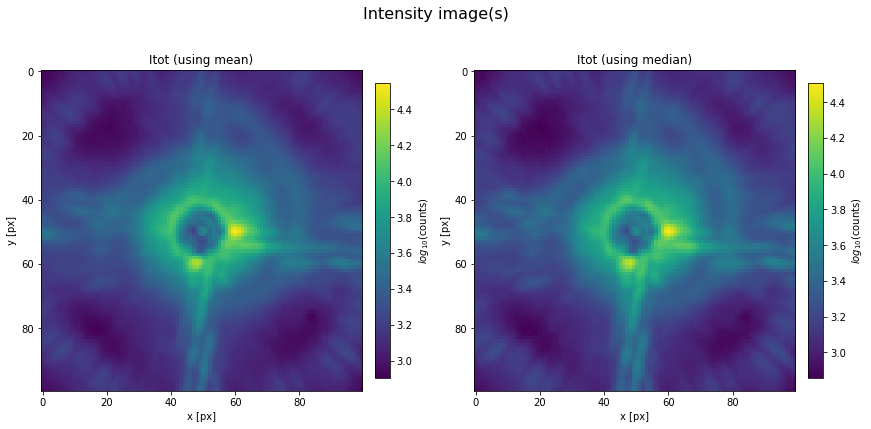

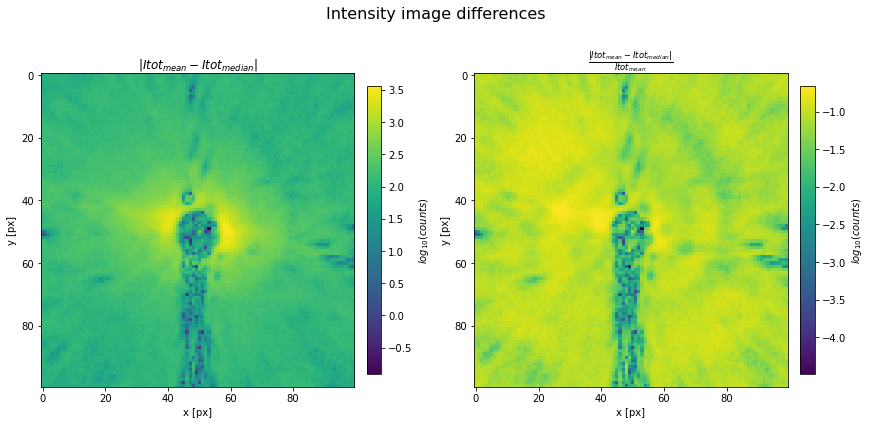

In [3]:
# Q2 answer here

# assuming the images are well aligned

Itot = np.mean(np.sum(im, axis=1), axis=0)

# in last weeks paper I read that they used a median to do something similar so I want to try that as well
# rationale is of course the higher stability when there are outliers
Itot_median = np.median(np.sum(im, axis=1), axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 6)) # figsize=(width, height)

axes = np.array(axes).flatten()
names = ["Itot (using mean)", "Itot (using median)"]

for i, (img, ax, name) in enumerate(zip([Itot, Itot_median], axes, names)):
    this_im = ax.imshow(np.log10(img),
                        vmin=None, vmax=None,
                       )
    plt.colorbar(this_im, ax=ax, label=r"$log_{10}$(counts)", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title(name) 
    
fig.suptitle('Intensity image(s)', fontsize=16)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 6)) # figsize=(width, height)

axes = np.array(axes).flatten()
names = [r"$|Itot_{mean} - Itot_{median}|$", r"$\frac{|Itot_{mean} - Itot_{median}|}{Itot_{mean}}$"]

for i, (img, ax, name) in enumerate(zip([Itot - Itot_median, (Itot - Itot_median) / Itot], axes, names)):
    this_im = ax.imshow(np.log10(np.abs(img)),
                        vmin=None, vmax=None,
                       )
    plt.colorbar(this_im, ax=ax, label=r"$log_{10}(counts)$", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title(name) 
    
fig.suptitle('Intensity image differences', fontsize=16)
plt.show()


# Q2 end of answer

<span style="  font-size:1.5em; color: Orange;">Comment:</span>

Interesting to see where they disagree. The areas where the errors are large is where there are larger disagreements between the images at different orientations and hence polarisations. 

Each `L` and `R` image pair are orthogonal polarisations. From the expressions in the [*equations* given before](#equation1) we find that summing and differencing the image pairs will produce an intensity and a polarisation image respectively.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.3</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Create `spos` and `sneg`, which are the sum and difference of the `L` and `R` images respectively.**
*  **Write both images out to FITS images (call them `SPOS.fits` and `SNEG.fits`)**
*  **Check that the SNEG images have the butterfly pattern in them in `ds9`.**
*  **Use `imshow` with `vmin=-1000` and `vmax=1000` and display the 0 degree image in `sneg`.**


<div class="alert alert-block alert-info">
<b>SANITY CHECK :</b> Check that you have subtracted the correct dimensions by printing out the <code>shape</code> of both of these arrays. Think about what you expect the <code>shape</code> of the output arrays to be. </div>

5.  **Join dimension 1 of `sneg` and `spos` together into `sdif`.**

<span style="  font-size:1.2em; color: Orange;">This is a little ambigous, especially since we talk about np arrays and we want to concentate along the dimension where we just summed or differenced. E.g. I squeeze the arrays ( I hope that doesnt come back to bite me later) so that my dimensions are different from what you have. (At least that is how I interpret it, altough Im not 100% sure about the nomenclature.)</span>


<div class="alert alert-block alert-info">
<b>Tip: </b> Joining axes together can be done using the module <code>np.concatenate()</code> </div>

---

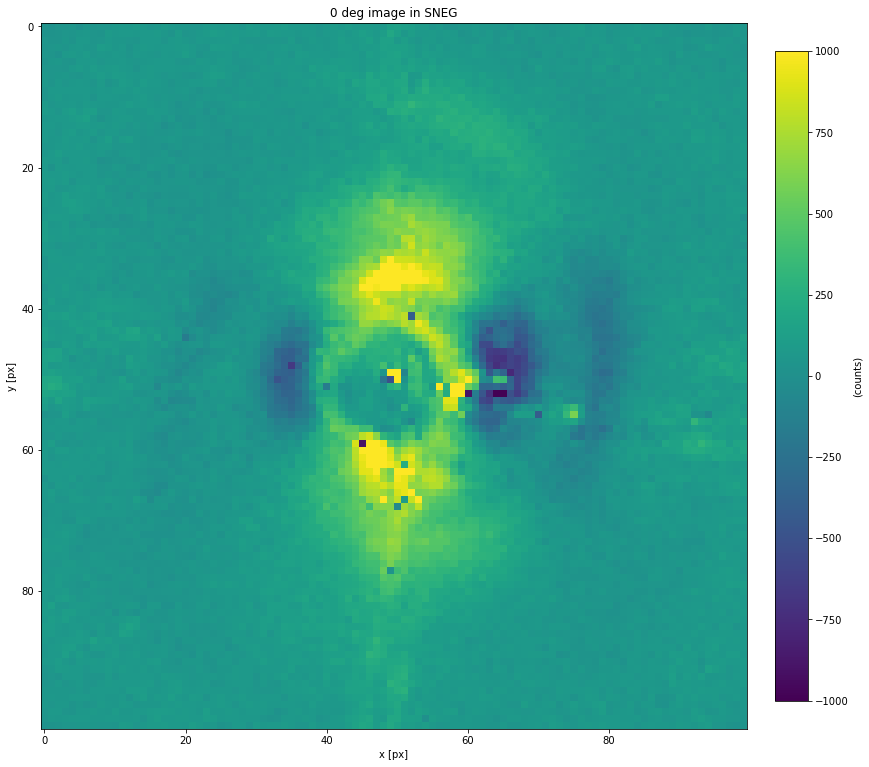

I squeezed the singleton dimension out.
The spos array has shape (4, 100, 100)
The sneg array has shape (4, 100, 100)
The sdif array has shape (4, 2, 100, 100)


In [4]:
# Q3 answer here

spos = np.squeeze(np.sum(im, axis=1))
hdu = fits.PrimaryHDU(spos)
hdu.writeto('SPOS.fits', overwrite=True)

sneg = np.squeeze(np.diff(im, axis=1))
hdu = fits.PrimaryHDU(sneg)
hdu.writeto('SNEG.fits', overwrite=True)


sdif = np.stack((sneg, spos), axis=1)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(sneg[0],
                    vmin=-1000, vmax=1000)
plt.colorbar(this_im, ax=ax, label=r"(counts)", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("0 deg image in SNEG") 
plt.show()



# Q3 end of answer
print("I squeezed the singleton dimension out.")
print("The spos array has shape {}".format(spos.shape))
print("The sneg array has shape {}".format(sneg.shape))
print("The sdif array has shape {}".format(sdif.shape))

We can even kinda see the imprint of a disk and what looks like spirals already!

## Making a polarization image

We can now look at the nearly face-on dust disk of the star for the first time by calculating the Polarised Intensity, $I_{pol}$. The polarised itensity is given by $$I_{pol} = \sqrt{Q^2 + U^2}$$

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.4</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Calculate the polarised intensity by using the `sneg` images**

1. **Define Q to be the first dimension image of `sneg`, and U as the second dimension image of `sneg`.** <span style="  font-size:1.2em; color: Orange;">What does this mean? :( Does this mean the different positions in the cube? They are along the same dimension.</span>


2.  **Calculate the polarised intensity, and call the image `Ipol`**
*  **Display the image `Ipol` in the range $0$ to $1500$.**

**Can you identify the disk already?**

---

<span style="  font-size:1.2em; color: Orange;">I will also use the actual formula for Ipol so that my result might differ by a factor of 2 from what is wanted, depending on the operations on SNEG (Q, U) beforehand.  I adjus the scale accordingly.</span>


<a id='equation90'></a>

$$\begin{aligned}
S_0(L) &= I + Q + Q_{IP}\\
S_1(L) &= I + U + U_{IP}\\
S_2(L) &= I - Q + Q_{IP}\\
S_3(L) &= I - U + U_{IP}\\
&\;\;\;\;\;\text{and}\\
S_0(R) &= I - Q + Q_{IP}\\
S_1(R) &= I - U + U_{IP}\\
S_2(R) &= I + Q + Q_{IP}\\
S_3(R) &= I + U + U_{IP} \end{aligned}$$

<a id='equation91'></a>

$$\begin{aligned}
S_0 &= I - Q + Q_{IP} -( I + Q + Q_{IP})\\
S_1 &= I - U + U_{IP} -( I + U + U_{IP})\\
S_2 &= I + Q + Q_{IP} -( I - Q + Q_{IP})\\
S_3 &= I + U + U_{IP} -( I - U + U_{IP})\end{aligned}$$

<a id='equation92'></a>

assuming instrument polarization is zero:

$$\begin{aligned}
S_0 &= - Q -(Q)    &= - 2Q \\
S_1 &= - U -(U)    &= - 2U \\
S_2 &= Q -(- Q ) &= 2Q \\
S_3 &= U -(- U ) &= 2U \end{aligned}$$

So Im quite confused as I indicated in orange in the box above. What are the differnt dimensions we are supposeed to tkae the images along? Because right now Im doing the same as for the later question. Maybe you mean to get Ipol using:

$\texttt{Ipol = np.sqrt(np.square((sneg[0]) * 0.5) + np.square((sneg[1]) * 0.5))}$

(Which of course produces a much worse image). 
So I really dont quite get what we are supposed to do here. I guess the difference that you want to show us is how overdetermining the polarization improves the image quality by also taking the +/- 45 degree polarization into account. Feel free to un comment one or the other version.


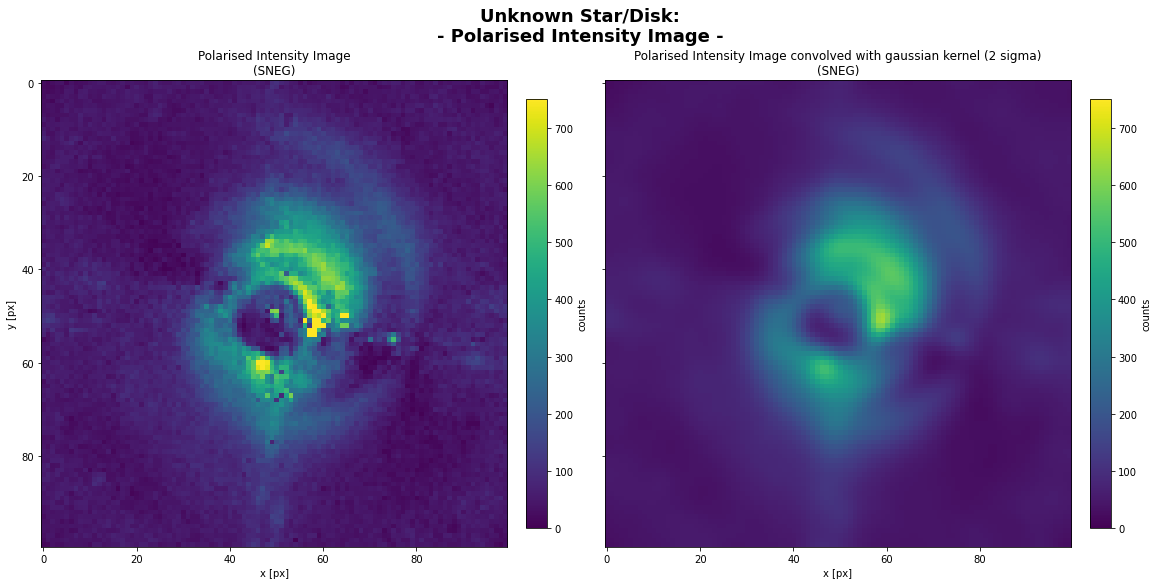

The Ipol image has shape (100, 100)


In [5]:
# Q4 answer here
# sneg = np.expand_dims(sneg, axis=1) # it did
# print("The sneg array now has shape {}".format(sneg.shape))

# cool version with polarization overdetermination:
# Ipol = np.sqrt(np.square((- sneg[0] + sneg[2] ) * 0.5**2) + np.square((- sneg[1] + sneg[3]) * 0.5**2))
# what I think you want us to do? - really unsure.
Ipol = np.sqrt(np.square((sneg[0]) * 0.5) + np.square((sneg[1]) * 0.5))

try:
    from astropy.convolution import Gaussian2DKernel
    from astropy.convolution import convolve
    kernel = Gaussian2DKernel(x_stddev=2)
    Ipol_conv = convolve(Ipol, kernel, boundary="extend")
    
    Ipoly_conv = Ipol_conv[49, :]
    Ipolyslice_conv = Ipol_conv[46:53, :]
    
    fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                                  constrained_layout=True,
                                  sharey=True,
                                  figsize=(16, 8)) # figsize=(width, height)
          
    this_im = ax.imshow(Ipol,
                    vmin=0, vmax=750)
    plt.colorbar(this_im, ax=ax, label=r"counts", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title("Polarised Intensity Image\n(SNEG)") 

    this_im = ax1.imshow(Ipol_conv,
                        vmin=0, vmax=750)
    plt.colorbar(this_im, ax=ax1, label=r"counts", fraction=0.046, pad=0.04)
    ax1.set_xlabel('x [px]')
    ax1.set_title("Polarised Intensity Image convolved with gaussian kernel (2 sigma)\n(SNEG)") 
    
except BaseException:
    fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12)) # figsize=(width, height)

    this_im = ax.imshow(Ipol,
                        vmin=0, vmax=750)
    plt.colorbar(this_im, ax=ax, label=r"(counts)", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title("Polarised Intensity Image\n(SNEG)") 
    

fig.suptitle('Unknown Star/Disk:\n- Polarised Intensity Image -', fontsize=18, weight="bold")
plt.show()

# Q4 end of answer

print("The Ipol image has shape {}".format(Ipol.shape))

It certianly looks like a disk with at least a ring ane potentially two spiral arms. The might also be another ring which is seperated from the outer one by a gap but that is difficult to tell because of the artifacts (the gaps are in-line with artifacts in the image).

## Plotting up the gain in contrast

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Plot the flux of row number 50 in `Itot` as function of pixel. Overplot the same row in `Ipol` on the same graph. Make the y-axis have a logarithmic scale by using `ax=plt.gca()` to get the name of the current plotting window, and `ax.set_yscale('log')` to make it logarithmic.**

<div class="alert alert-block alert-info">
<b>Remember :</b>  Label the axes as "Spatial cut across image [pix]" and a suitable title and units for the y-axis. Add a legend to distinguigh the two plots.</div>

**Describe what you see**

---


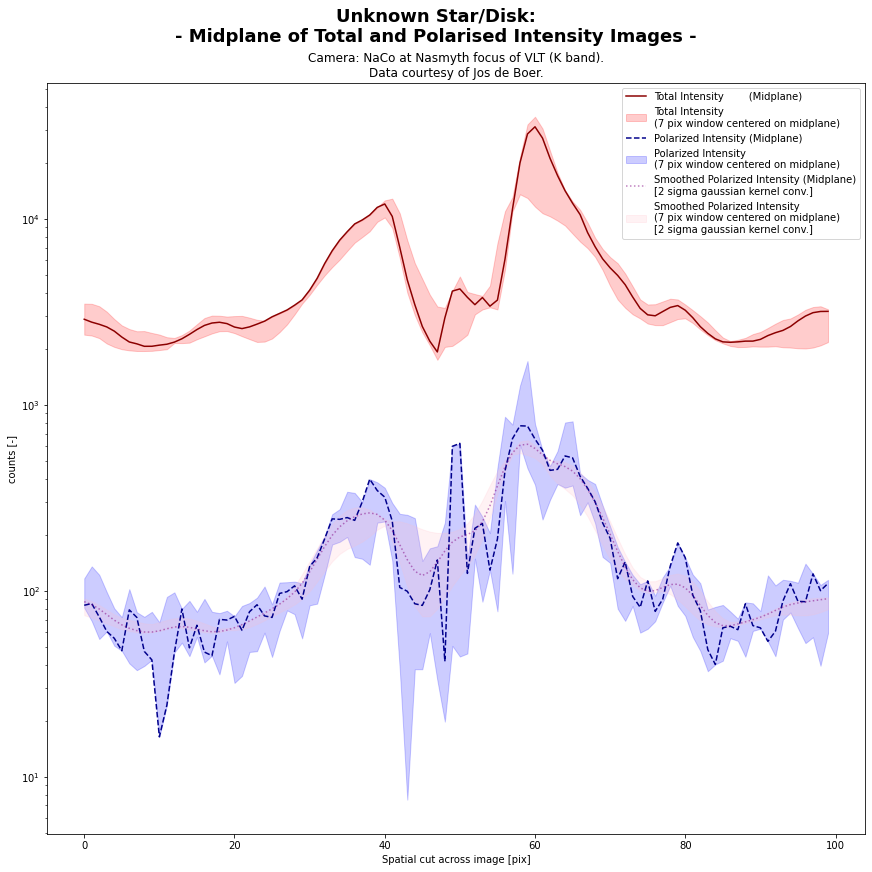

In [6]:
# Q5 answer here

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

Itoty = Itot[49, :]
Ipoly = Ipol[49, :]

# Error bars because I like them
Itotyslice = Itot[46:53, :]
Ipolyslice = Ipol[46:53, :]

x = np.arange(len(Itoty))

ax.plot(x, Itoty, c="darkred", ls="solid",   label="Total Intensity        (Midplane)")
ax.fill_between(x,
                 np.min(Itotyslice, axis=0),
                 np.max(Itotyslice, axis=0),
                 alpha=0.2, color="red", label="Total Intensity\n(7 pix window centered on midplane)")


ax.plot(x, Ipoly, c="darkblue", ls="dashed", label="Polarized Intensity (Midplane)")
ax.fill_between(x,
                 np.min(Ipolyslice, axis=0),
                 np.max(Ipolyslice, axis=0),
                 alpha=0.2, color="blue", label="Polarized Intensity\n(7 pix window centered on midplane)")

try:
    ax.plot(x, Ipoly_conv, c="purple", ls="dotted", label="Smoothed Polarized Intensity (Midplane)\n[2 sigma gaussian kernel conv.]",
           alpha=0.5)
    ax.fill_between(x,
                 np.min(Ipolyslice_conv, axis=0),
                 np.max(Ipolyslice_conv, axis=0),
                 alpha=0.2, color="pink", label="Smoothed Polarized Intensity\n(7 pix window centered on midplane)\n[2 sigma gaussian kernel conv.]")
except BaseException:
    pass

ax.set_xlabel(r'Spatial cut across image [pix]')
ax.set_ylabel(r'counts [-]')
# ax.set_ylim(0., None)
ax.set_yscale('log')
ax.legend()
ax.set_title('Camera: NaCo at Nasmyth focus of VLT (K band).\nData courtesy of Jos de Boer.') 
fig.suptitle('Unknown Star/Disk:\n- Midplane of Total and Polarised Intensity Images -', fontsize=18, weight="bold")
plt.show()

# Q5 end of answer

For both images we see something that looks like a ring at first. The total flux in Itot image is of course much higher than in the polarized intensity image. The contrast between ring and non ring (suspected) regions is increased for the polarized intensity image since we extinct (some) flux that is not polarized by the disk. However we also increase the contrast of outliers (i.e. if there is abnoramlly high flux in some pixels in one image it will not get extincted). Smoothing over these pixels can help clean up the image but is very dangerous since the convolution with a gaussian does not distingish between flux that is noise and interesting, i.e. we can loose some information (what if there is a planet hiding there?!). This is e.g. visible for the decrease contrast of the potential ring at 80 pixels, for which the contrast is only as good as it was in the total flux image. Also see the image below.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.6</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Plot the ratio of the two lines above. By doing so, you get an idea of the fractional polarisation that is measured.**

**Write down what the polarisation level is. Round your answer to whole percentages.**

---

Using a smoothed polarized intensity image the polarisation level is 3 +/- 1 precent.


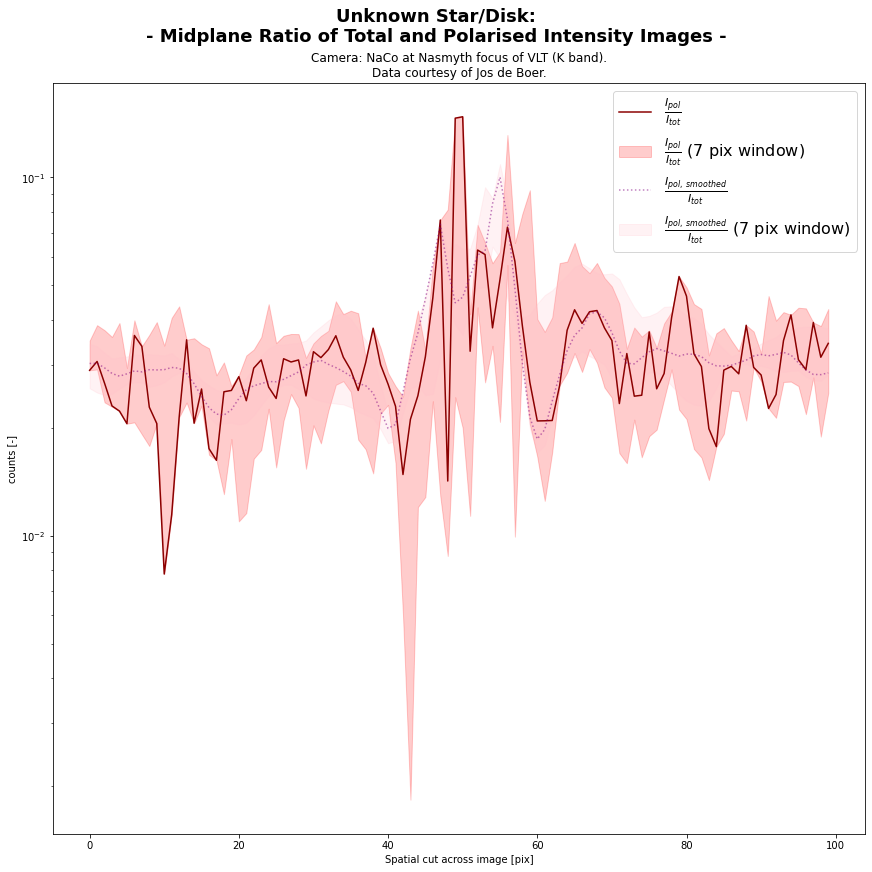

The polarisation level is 3 +/- 2 precent.


In [7]:
# Q6 answer here

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, Ipoly / Itoty, c="darkred", ls="solid",   label=r"$\frac{I_{pol}}{I_{tot}}$")
ax.fill_between(x,
                 np.min(Ipolyslice / Itotyslice, axis=0),
                 np.max(Ipolyslice / Itotyslice, axis=0),
                 alpha=0.2, color="red", label=r"$\frac{I_{pol}}{I_{tot}}$ (7 pix window)")

try:
    ax.plot(x, Ipoly_conv/ Itoty, c="purple", ls="dotted", label=r"$\frac{I_{pol, ~ smoothed}}{I_{tot}}$",
           alpha=0.5)
    ax.fill_between(x,
                 np.min(Ipolyslice_conv / Itotyslice, axis=0),
                 np.max(Ipolyslice_conv / Itotyslice, axis=0),
                 alpha=0.2, color="pink", label=r"$\frac{I_{pol, ~ smoothed}}{I_{tot}}$ (7 pix window)")
    print(f"Using a smoothed polarized intensity image the polarisation level is {np.mean(Ipoly_conv / Itoty) * 100:.0f} +/- {np.std(Ipoly_conv / Itoty) * 100:.0f} precent.")
except BaseException:
    pass

ax.set_xlabel(r'Spatial cut across image [pix]')
ax.set_ylabel(r'counts [-]')
# ax.set_ylim(0., None)
ax.set_yscale('log')
ax.legend(fontsize=16)
ax.set_title('Camera: NaCo at Nasmyth focus of VLT (K band).\nData courtesy of Jos de Boer.') 
fig.suptitle('Unknown Star/Disk:\n- Midplane Ratio of Total and Polarised Intensity Images -', fontsize=18, weight="bold")
plt.show()


# Q6 end of answer

print(f"The polarisation level is {np.around(np.mean(Ipoly / Itoty) * 100):.0f} +/- {np.around(np.std(Ipoly / Itoty) * 100):.0f} precent.")



## Double difference

As mentioned in the introduction of this notebook, we have more images than there are parameters to measure. So, why do we have this extra data? We are measuring polarization by comparing intensities of the images. However, there is no guarantee that the transmission of optics forming the `L` and `R` images are the same. In addition, since we have to take a series of images in time, the instrument and the atmospheric conditions may have changed as well.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.7</span> <span style="  font-size:1em; color: SteelBlue;">
(1 points): </span>

**Using the definitions of $S(L)$ and $S(R)$ from the top of the practicum, write out what `spos` and `sneg` are in terms of `Q` and `U`.**

---
 

You see that you have four independent measurements of `I` and two independent measurements of `Q` and `U` in `spos` and `sneg`.  We can average the values in `spos` together to get `I`, thus combine the $S_0$ and $S_2$ components in `spos` to get `I`. To get `U` and `Q`, we can average the values in `sneg` together.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.8</span> <span style="  font-size:1em; color: SteelBlue;">
(3 points): </span>

1. **With `sneg`, combine the $S_0$ and $S_2$ values to get a value for `Q`.**
* **Combine the $S_1$ and $S_3$ values to get a value for `U`.**
* **Calculate the polarisation `P` using the same formula as for `Ipol`.**

---

The angle of polarisation $\chi$ indicates the angle between the plane of polarisation and the plane of reference. This angle can be described by the formula:

$$\chi = \frac{1}{2}\arctan(\texttt{U}/\texttt{Q})$$

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.9</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Calculate the angle of polarisation, $\chi$, using the formula above. Call it `X`**

---


Also see the equations above.

<a id='equation93'></a>

$$\begin{aligned}
S_0(L) &= I + Q + Q_{IP}\\
S_1(L) &= I + U + U_{IP}\\
S_2(L) &= I - Q + Q_{IP}\\
S_3(L) &= I - U + U_{IP}\\
&\;\;\;\;\;\text{and}\\
S_0(R) &= I - Q + Q_{IP}\\
S_1(R) &= I - U + U_{IP}\\
S_2(R) &= I + Q + Q_{IP}\\
S_3(R) &= I + U + U_{IP} \end{aligned}$$

Assuming instrument polarization is negligable:

SNEG:
<a id='equation94'></a>
$$\begin{aligned}
S_0 &= - Q -(Q)    &= - 2Q \\
S_1 &= - U -(U)    &= - 2U \\
S_2 &= Q -(- Q ) &= 2Q \\
S_3 &= U -(- U ) &= 2U \end{aligned}$$

SPOS:
<a id='equation95'></a>
$$\begin{aligned}
S_0 &= 2I\\
S_1 &= 2I\\
S_2 &= 2I\\
S_3 &= 2I\end{aligned}$$

To get independent measurements we use both SPOS and SNEG.

$$I = 0.5 \cdot \left \langle \mathbf{SPOS} \right \rangle$$
$$Q = 0.5 \cdot\left \langle \begin{pmatrix}
-1\\ 
1
\end{pmatrix} \cdot  \mathbf{SNEG_{0, ~2}}\right \rangle$$
$$U = 0.5 \cdot \left \langle \begin{pmatrix}
-1\\ 
1
\end{pmatrix} \cdot  \mathbf{SNEG_{1, ~3}}\right \rangle$$

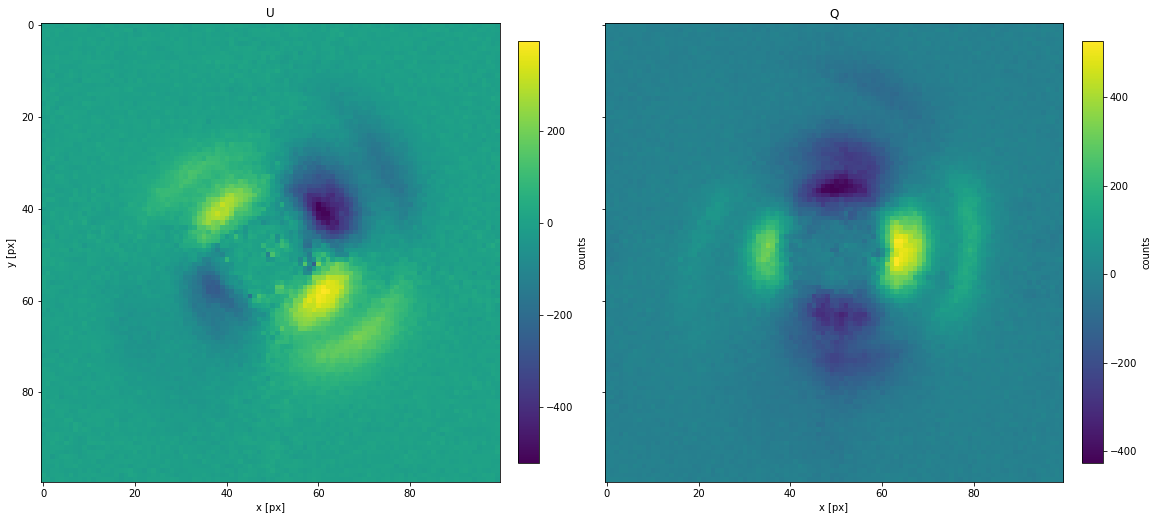

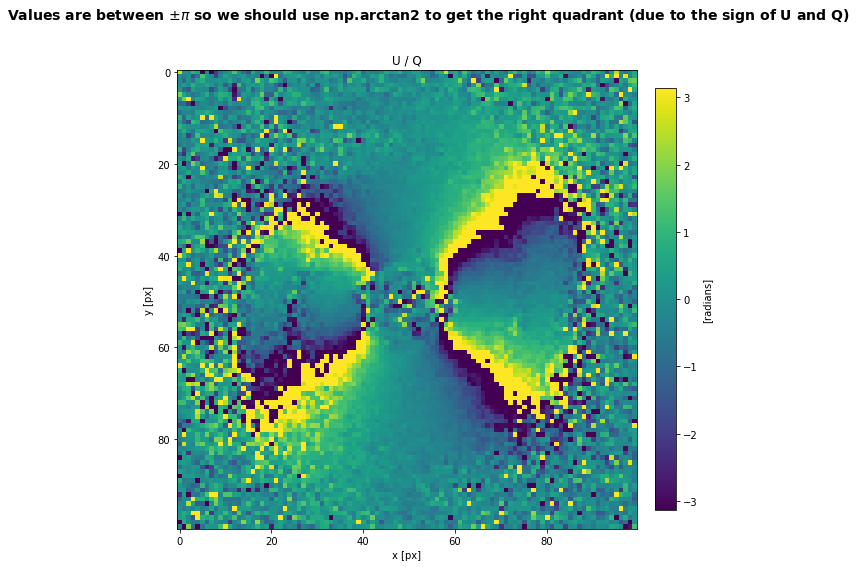

In [8]:
# Q7, Q8, Q9 answers here

I = 0.5 * np.mean(spos, axis=0)
I_median = 0.5 * np.median(spos, axis=0)
Q = 0.5**2 * (- sneg[0] + sneg[2])
U = 0.5**2 * (- sneg[1] + sneg[3])

fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                              constrained_layout=True,
                              sharey=True,
                              figsize=(16, 8)) # figsize=(width, height)

this_im = ax.imshow(U,
                vmin=None, vmax=None)
plt.colorbar(this_im, ax=ax, label=r"counts", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("U") 

this_im = ax1.imshow(Q,
                    vmin=None, vmax=None)
plt.colorbar(this_im, ax=ax1, label=r"counts", fraction=0.046, pad=0.04)
ax1.set_xlabel('x [px]')
ax1.set_title("Q") 
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,
                              constrained_layout=True,
                              sharey=True,
                              figsize=(8, 8)) # figsize=(width, height)

this_im = ax.imshow(U / Q,
                    vmin=-np.pi, vmax=np.pi)
plt.colorbar(this_im, ax=ax, label=r"[radians]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("U / Q") 

fig.suptitle(r'Values are between $\pm \pi$ so we should use np.arctan2 to get the right quadrant (due to the sign of U and Q)', fontsize=14, weight="bold")
plt.show()


# ========================================

Ipol = np.sqrt(np.square(Q) + np.square(U))


X = 0.5 * np.arctan(U / Q)
X2 = 0.5 * np.arctan2(U, Q)


# Q7, Q8, Q9 end of answers 


## Polarization image versus Fractional polarization image

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.10</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

1. **Display the polarization image with the min, max, pixel values (0-1500).**
2. **Mask out a circle of radius 5 pixels in the middle of the polarisation image.** 
3.  **Display the masked fractional polarisation IMAGE with (P/I) from 0 to 15% polarisation**


<div class="alert alert-block alert-info">
<b>Recall:</b>  The value of 0.10 in the fractional polarisation image stands for 10% polarisation.</div>

---

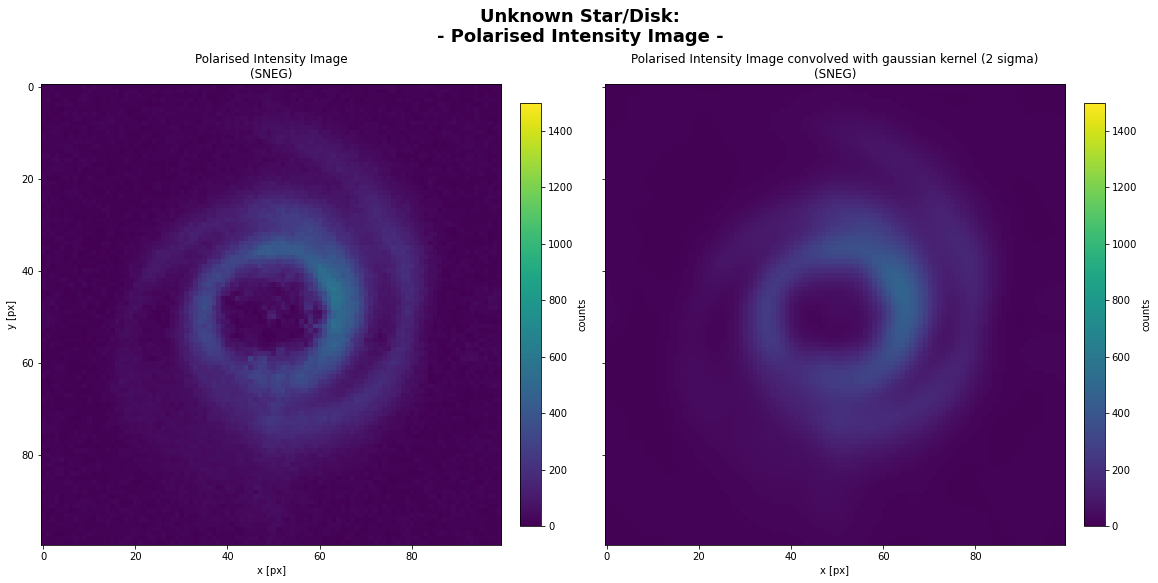

The Ipol image has shape (100, 100)


In [9]:
Ipol = np.sqrt(np.square(Q) + np.square(U))

# Q10 answer here

try:
    from astropy.convolution import Gaussian2DKernel
    from astropy.convolution import convolve
    kernel = Gaussian2DKernel(x_stddev=2)
    Ipol_conv = convolve(Ipol, kernel, boundary="extend")
    
    Ipoly_conv = Ipol_conv[49, :]
    Ipolyslice_conv = Ipol_conv[46:53, :]
    
    fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                                  constrained_layout=True,
                                  sharey=True,
                                  figsize=(16, 8)) # figsize=(width, height)
          
    this_im = ax.imshow(Ipol,
                    vmin=0, vmax=1500)
    plt.colorbar(this_im, ax=ax, label=r"counts", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title("Polarised Intensity Image\n(SNEG)") 

    this_im = ax1.imshow(Ipol_conv,
                        vmin=0, vmax=1500)
    plt.colorbar(this_im, ax=ax1, label=r"counts", fraction=0.046, pad=0.04)
    ax1.set_xlabel('x [px]')
    ax1.set_title("Polarised Intensity Image convolved with gaussian kernel (2 sigma)\n(SNEG)") 
    
    
except BaseException:
    fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12)) # figsize=(width, height)

    this_im = ax.imshow(Ipol,
                        vmin=0, vmax=1500)
    plt.colorbar(this_im, ax=ax, label=r"counts", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title("Polarised Intensity Image\n(SNEG)") 
    
    
fig.suptitle('Unknown Star/Disk:\n- Polarised Intensity Image -', fontsize=18, weight="bold")
plt.show()
    
print("The Ipol image has shape {}".format(Ipol.shape))



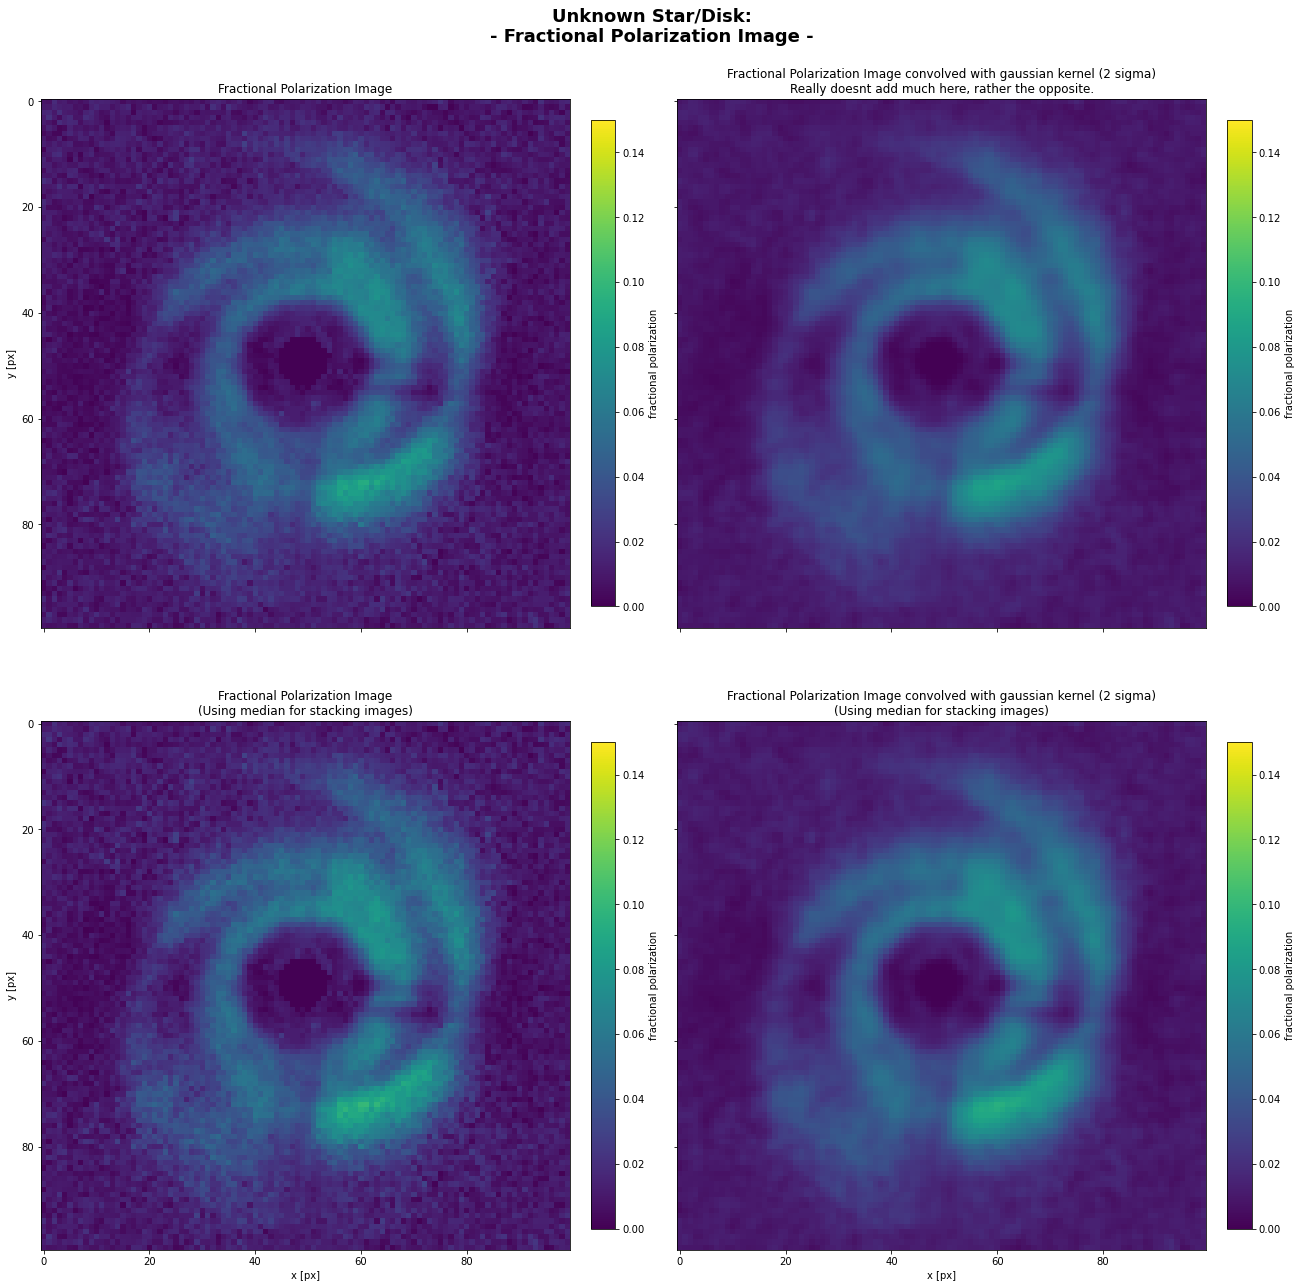

In [10]:
mask = circle_mask(Ipol, 49, 49, 5)

Fpol = Ipol / Itot
Fpol_median = Ipol / Itot_median

Fpol[mask] = 0.
Fpol_median[mask] = 0.


try:
    from astropy.convolution import Gaussian2DKernel
    from astropy.convolution import convolve
    kernel = Gaussian2DKernel(x_stddev=0.75)
    
    fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2,
                                  constrained_layout=True,
                                  sharey=True, sharex=True,
                                  figsize=(18, 18)) # figsize=(width, height)
    
    Fpol_conv = convolve(Fpol, kernel, boundary="extend")
    
          
    this_im = ax.imshow(Fpol,
                    vmin=0, vmax=0.15)
    plt.colorbar(this_im, ax=ax, label=r"fractional polarization", fraction=0.046, pad=0.04)
    ax.set_ylabel('y [px]')
    ax.set_title("Fractional Polarization Image") 

    this_im = ax1.imshow(Fpol_conv,
                        vmin=0, vmax=0.15)
    plt.colorbar(this_im, ax=ax1, label=r"fractional polarization", fraction=0.046, pad=0.04)
    ax1.set_title("Fractional Polarization Image convolved with gaussian kernel (2 sigma)\nReally doesnt add much here, rather the opposite.") 
    
    # =====
    
    Fpol_conv = convolve(Fpol_median, kernel, boundary="extend")
    
    this_im = ax2.imshow(Fpol_median,
                    vmin=0, vmax=0.15)
    plt.colorbar(this_im, ax=ax2, label=r"fractional polarization", fraction=0.046, pad=0.04)
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.set_title("Fractional Polarization Image\n(Using median for stacking images)") 

    this_im = ax3.imshow(Fpol_conv,
                        vmin=0, vmax=0.15)
    plt.colorbar(this_im, ax=ax3, label=r"fractional polarization", fraction=0.046, pad=0.04)
    ax3.set_xlabel('x [px]')
    ax3.set_title("Fractional Polarization Image convolved with gaussian kernel (2 sigma)\n(Using median for stacking images)") 
    
    

except BaseException:
    fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12)) # figsize=(width, height)

    this_im = ax.imshow(Fpol,
                        vmin=0, vmax=0.15)
    plt.colorbar(this_im, ax=ax, label=r"fractional polarization", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title("Fractional Polarization Image") 

    
fig.suptitle('Unknown Star/Disk:\n- Fractional Polarization Image -', fontsize=18, weight="bold")
plt.show()




# Q10 answer here    

## Limits of signal to noise by looking at the polarization angle.

The scattered light should be at right angles to the line between any spot on the disk and the central star. Plotting the polarization angle and seeing where it degenerates into noise gives a good indication where the polarization signal lies.

---
<span style="  font-size:2em; color: SteelBlue;">Question 6.11</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Display the polarisation angle map.** 

**Give your best estimation of the radii into which there is good signal to noise (where you clearly can identify the polarisaition signal)**

---

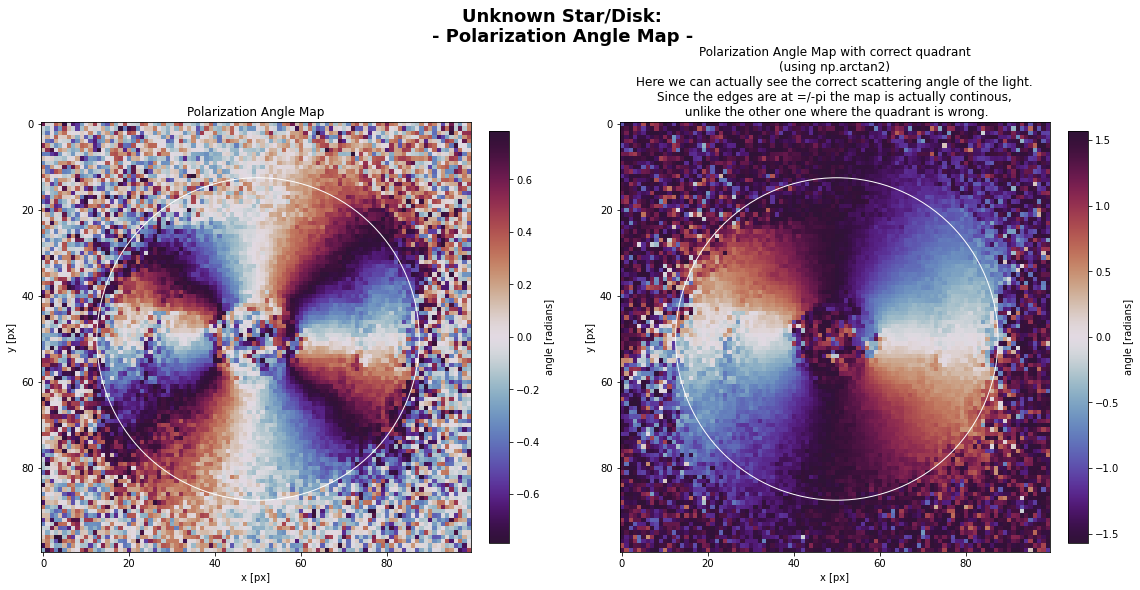

Radius where S>N is roughly 37.5.
The disk is probably not ~exactly~ face on so that it looks slightly elliptical from our perspective.


In [16]:
# Q12 answer here

import matplotlib as mpl
rad = 37.5
center = 50

fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                     constrained_layout=True,
                     figsize=(16, 8)) # figsize=(width, height)

this_im = ax.imshow(X,
                    vmin=-np.pi/4, vmax=np.pi/4, cmap='twilight_shifted')
plt.colorbar(this_im, ax=ax, label=r"angle [radians]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("Polarization Angle Map") 

p = mpl.patches.Circle((center, center), rad, fc="none", ec="w", ls="solid")
ax.add_artist(p)

this_im = ax1.imshow(X2,
                    vmin=-np.pi/2, vmax=np.pi/2, cmap='twilight_shifted')
plt.colorbar(this_im, ax=ax1, label=r"angle [radians]", fraction=0.046, pad=0.04)
ax1.set_xlabel('x [px]')
ax1.set_ylabel('y [px]')
ax1.set_title("Polarization Angle Map with correct quadrant\n(using np.arctan2)\nHere we can actually see the correct scattering angle of the light.\nSince the edges are at =/-pi the map is actually continous,\n unlike the other one where the quadrant is wrong.") 

p1 = mpl.patches.Circle((center, center), rad, fc="none", ec="w", ls="solid")
ax1.add_artist(p1)

fig.suptitle('Unknown Star/Disk:\n- Polarization Angle Map -', fontsize=18, weight="bold")
plt.show()

print(f"Radius where S>N is roughly {rad}.")
print(f"The disk is probably not ~exactly~ face on so that it looks slightly elliptical from our perspective.")

# Q12 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 6.13</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make a circular annular mask centered on the star that blocks out the star at radii and the noisy polarisation angles at large radii (estimate by eye what outer radius to use).**

**Use this mask to display the spiral arms in the disk in the fractional polarisation image.**


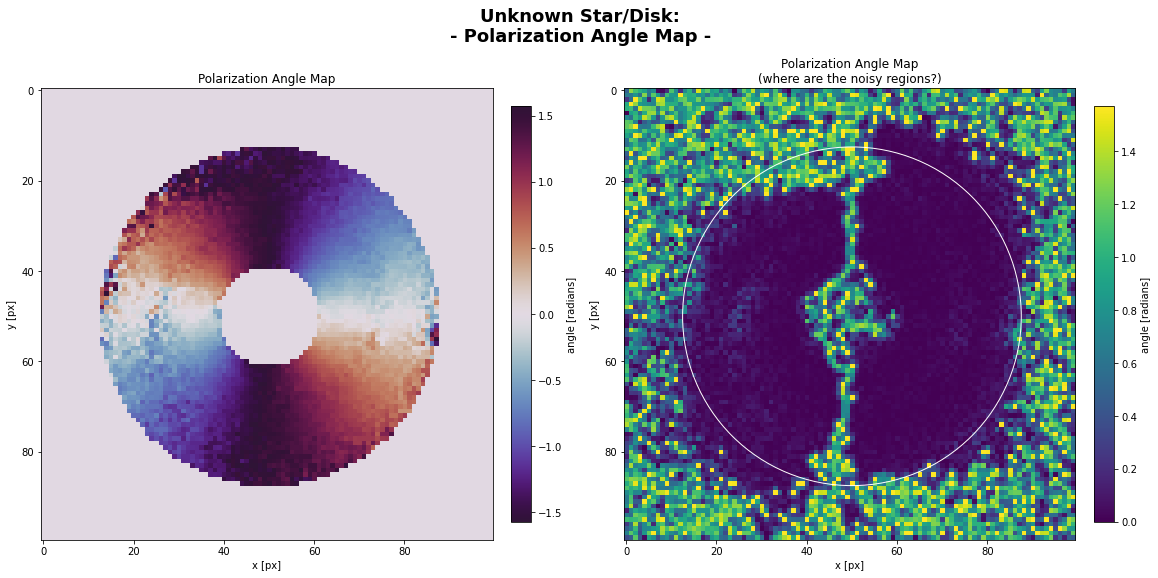

In [12]:
# Q13 answer here

mask2 = np.abs(circle_mask(Ipol, center, center, rad).astype(float)  - circle_mask(Ipol, center, center, 11).astype(float)).astype(bool)

fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                     constrained_layout=True,
                     figsize=(16, 8)) # figsize=(width, height)

this_im = ax.imshow(X2 * mask2,
                    vmin=-np.pi/2, vmax=np.pi/2, cmap='twilight_shifted')
plt.colorbar(this_im, ax=ax, label=r"angle [radians]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("Polarization Angle Map") 

X2_conv = convolve(X2, kernel, boundary="extend")

this_im = ax1.imshow(np.abs(X2_conv - X2),
                    vmin=0, vmax=np.pi/2, cmap='viridis')

p2 = mpl.patches.Circle((center, center), rad, fc="none", ec="w", ls="solid")
ax1.add_artist(p2)

plt.colorbar(this_im, ax=ax1, label=r"angle [radians]", fraction=0.046, pad=0.04)
ax1.set_xlabel('x [px]')
ax1.set_ylabel('y [px]')
ax1.set_title("Polarization Angle Map\n(where are the noisy regions?)") 

fig.suptitle('Unknown Star/Disk:\n- Polarization Angle Map -', fontsize=18, weight="bold")
plt.show()


# Q13 end of answer 

It could be argued that we need to use a smaller or larger radius because the phase fringes near the transitions (again since the values are at =/- pi) and hence it can be argues that more or less pixels can be included. As long as bad pixel values are accounted for a larger radius can be chosen. I will try this below. I use a continous colormap in the above images because of this exact reason: To not be thrown off by the discontinouety due to the cyclic phase value. The second plot shows excatly where the noisy regions are, i.e. where the transitions are not smooth anymore but dominated by radom counts (photon polarisations). In this we can also see the slight elongation of the disk ellipse and there there are probably spiral arms. Sweet!

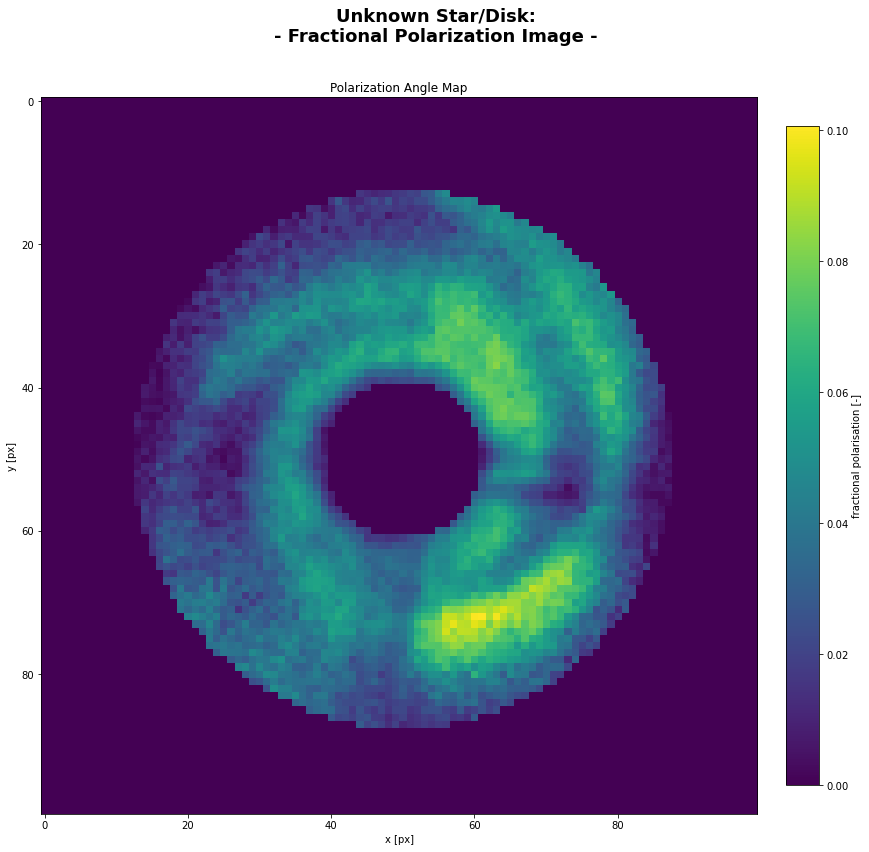

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(Fpol_median * mask2,
                    vmin=None, vmax=None)
plt.colorbar(this_im, ax=ax, label=r"fractional polarisation [-]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

fig.suptitle('Unknown Star/Disk:\n- Fractional Polarization Image -', fontsize=18, weight="bold")
plt.show()

I do the following:
1. I find the pixels where noise dominates using a convolution with a guassian
    1.5 I take the absolute values since I only need the absolute error
2. I mask the pixel where I know that I have no usable data (near star)
3. I mask the pixels where I know the periodic phase would throw off further convolutions (near +/- pi)
4. I convolve with a gaussian to find extended regions of low-trust (high noise)
    4.5 I choose the sigma abitrarily until the image looks sufficeintly smooth
    4.6 depending on how much we trust the CCD/camera/flux this can be lower or higher. 
    4.7 If we think that we mostly count the right values this can be lower (0-> direct trust for each pixel which is very risky/(stupid)) or higher if we dont trust like that and think that we need more pixels in a region to make a good judement of the noise there
    4.8 From intuition its quite obvious that we would like it to be somewhat smooth with increasing separation (in a low-trust scenario), so this is what I did.
5. I clip (mask out) at values where I see low-trust regions.
6. I re-normalize the trust map to [0, 1]

This is the trust map!

Some comments: We want to avoid/be careful using the trust map (assigning values other than 0 or 1) inside the region where we suspect the disk. This would lead to a kind of "double counting" where we use the phase to estimate the noise and the presence of scattering particles at the same time. This would amplify the disk presence, however this would be unjustified and can lead to wrongly rejecting the null hypothesis in case of a close (non-)detection. You can see this if you set the values sigma, tmin and tmax to the alternate ones below. The coolest part is that this method would also highlight other regions where a bunch of consistently polarized light is emitted!

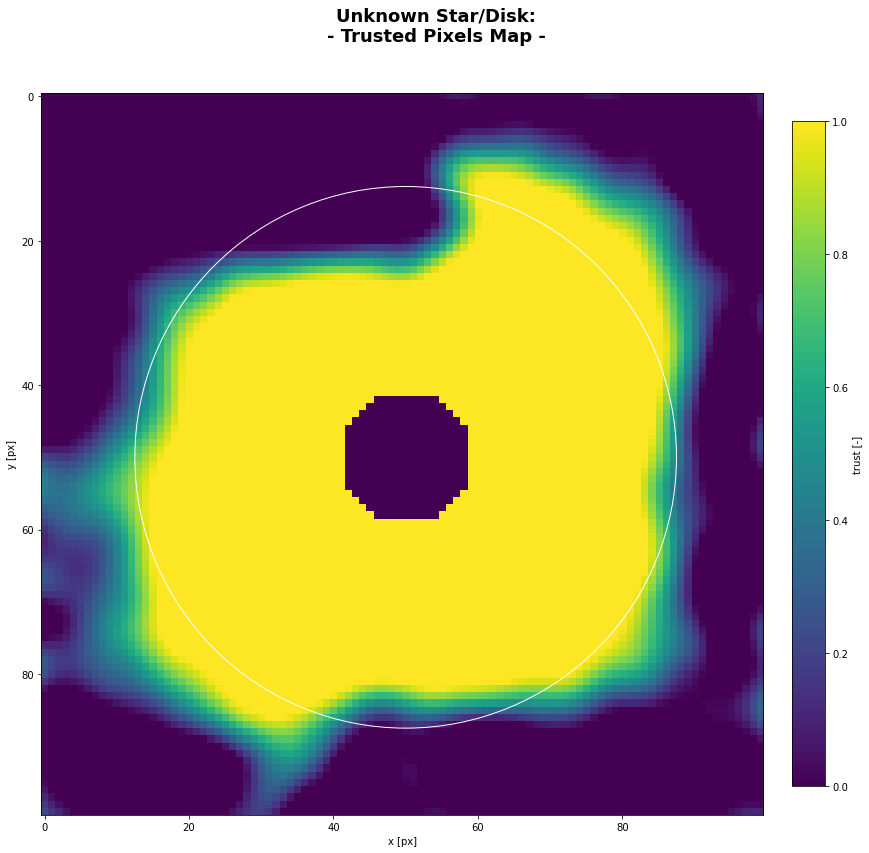

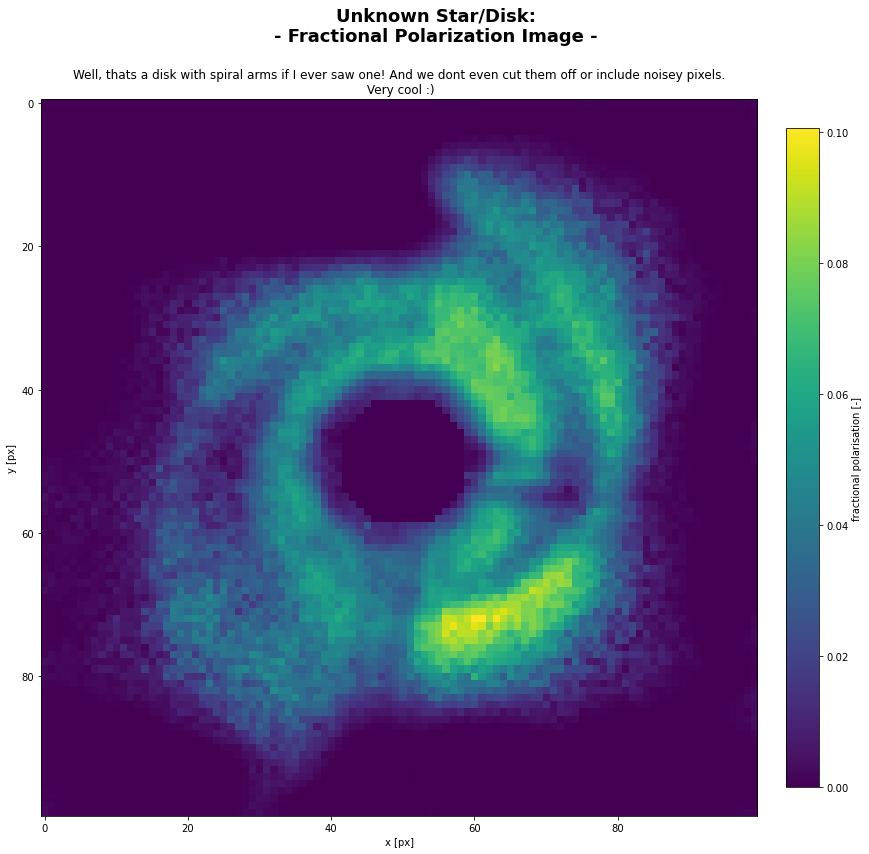

In [14]:
# lets give selecting a larger frame a try based on the good/bad pixel regions we see in the noise-spotting plot.

sigma = 3
tmin, tmax = 0.3, 0.85

# sigma = 2.5
# tmin, tmax = 0.3, 1.

bad_pixel_mask = np.abs(X2_conv - X2)
bad_pixel_mask *= np.abs(1 - circle_mask(Ipol, center, center, 11))
bad_pixel_mask[25:84, 35:55] = 0
kernel = Gaussian2DKernel(x_stddev=sigma)
bad_pixel_mask = convolve(bad_pixel_mask, kernel, boundary="extend")
bad_pixel_mask = np.clip(1 - bad_pixel_mask, a_min=tmin, a_max=tmax)
bad_pixel_mask = (bad_pixel_mask - np.min(bad_pixel_mask))/np.ptp(bad_pixel_mask)
bad_pixel_mask *= np.abs(1 - circle_mask(Ipol, center, center, 9))

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(bad_pixel_mask,
                    vmin=None, vmax=None)

p3 = mpl.patches.Circle((center, center), rad, fc="none", ec="w", ls="solid")
ax.add_artist(p3)

plt.colorbar(this_im, ax=ax, label=r"trust [-]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

fig.suptitle('Unknown Star/Disk:\n- Trusted Pixels Map -', fontsize=18, weight="bold")
plt.show()

# lets use it!

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(Fpol_median * bad_pixel_mask,
                    vmin=None, vmax=None)
plt.colorbar(this_im, ax=ax, label=r"fractional polarisation [-]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title("Well, thats a disk with spiral arms if I ever saw one! And we dont even cut them off or include noisey pixels.\n Very cool :)") 

fig.suptitle('Unknown Star/Disk:\n- Fractional Polarization Image -', fontsize=18, weight="bold")
plt.show()


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it! Do only upload the notebook to Brightspace in the correct naming format.</div>


---

<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [15]:
# Number of hours taken for this practicum:
# 6ish hours I think